In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import rcParams
import warnings
warnings.filterwarnings('ignore')

import re
import jax.numpy as jnp
from jax import grad, jit, partial
import ticktack
from ticktack import fitting
from tqdm import tqdm
import scipy

rcParams['figure.figsize'] = (8.0, 4.0)

In [2]:
cbm = ticktack.load_presaved_model('Guttler14', production_rate_units = 'atoms/cm^2/s')
cf = fitting.CarbonFitter(cbm)
cf.load_data('inject_recovery_gp_noise.csv')
cf.prepare_function(use_control_points=True, interp='gp')

In [3]:
import inspect
print(inspect.getsource(cf.loss_chi2))

    @partial(jit, static_argnums=(0,))
    def loss_chi2(self, params=()):
        d_14_c = self.dc14(params=params)
        chi2 = jnp.sum(((self.d14c_data[:-1] - d_14_c) / self.d14c_data_error[:-1]) ** 2)
        chi2 += 10 * jnp.sum(((self.d14c_data[:4] - d_14_c[:4]) / self.d14c_data_error[:4]) ** 2)
        return 0.5*chi2



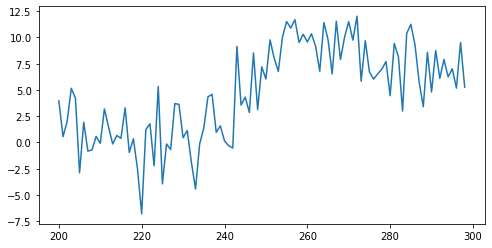

In [4]:
plt.plot(cf.time_data, cf.d14c_data)

In [5]:
@jit
def gauss(t):
    prod =  1.87 + 0.2 * 1.87 * jnp.exp(-1/2*((t-250)/10)**2.)
    return prod

In [6]:
cf.offset

DeviceArray(2.92053742, dtype=float64)

In [7]:
cf.offset = 0
cf.offset

0

In [8]:
%%time
soln = cf.fit_cp(low_bound=0.)

CPU times: user 12min 1s, sys: 5.88 s, total: 12min 7s
Wall time: 10min 39s


In [9]:
soln.message

'STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT'

In [10]:
print("total likelihood: ", cf.gp_likelihood(soln.x))
print("gp likelihood: ", cf.gp_neg_log_likelihood(soln.x))
print("chi2: ", cf.loss_chi2(soln.x))

total likelihood:  135.72779629199542
gp likelihood:  110.34170083546151
chi2:  25.386095456533912


Text(0.5, 1.0, 'gauss production rate')

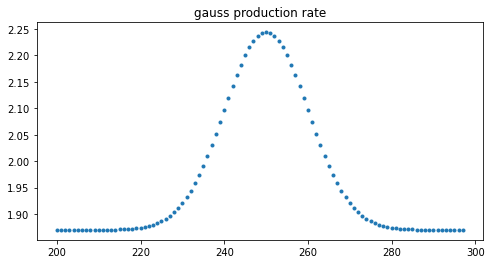

In [11]:
t = cf.control_points_time
true_cp = gauss(t)
plt.plot(t, gauss(t), ".")
plt.title('gauss production rate')

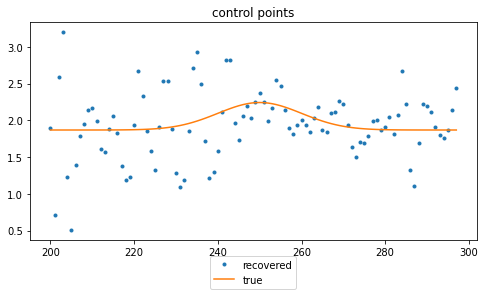

In [12]:
plt.plot(t, soln.x, ".", label="recovered")
plt.plot(t, true_cp, label='true')
plt.title("control points");
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True)

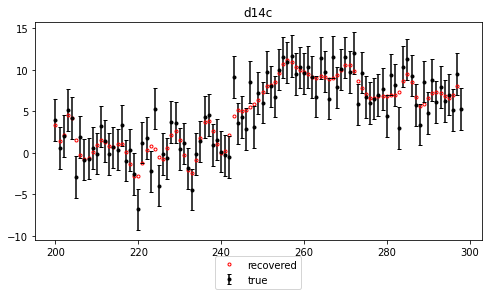

In [19]:
plt.plot(cf.time_data[:-1], cf.dc14(soln.x), "or", fillstyle="none", label="recovered", markersize=3)
# plt.plot(cf.time_data, cf.d14c_data, '--r')
plt.errorbar(cf.time_data, cf.d14c_data, yerr=cf.d14c_data_error, fmt='.k', fillstyle="full", capsize=2, 
             label="true")
plt.title("d14c");
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True)

In [14]:
t = np.arange(cf.start-10, cf.start+10, 0.1)

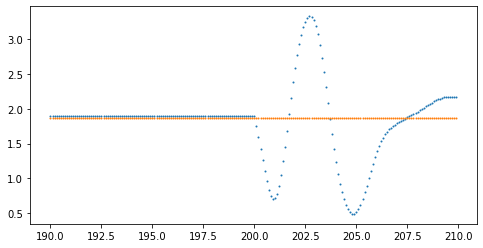

In [15]:
mu = cf.production(t, (soln.x,))
plt.plot(t, mu, ".", markersize=2)
plt.plot(t, gauss(t), ".", markersize=2)

In [16]:
soln.x

array([1.89947427, 0.71167141, 2.58755501, 3.1979937 , 1.23469609,
       0.50928885, 1.39271209, 1.79188976, 1.95677047, 2.13582854,
       2.16596933, 1.99641133, 1.61608934, 1.57612866, 1.88479158,
       2.05873632, 1.83092572, 1.37730342, 1.18464143, 1.23658699,
       1.94194294, 2.67594473, 2.33462821, 1.8499641 , 1.58772492,
       1.32746418, 1.91328632, 2.53021458, 2.53713649, 1.88160292,
       1.27889324, 1.09537423, 1.18386161, 1.85126702, 2.71633946,
       2.92877965, 2.49673123, 1.71689234, 1.22020185, 1.30224401,
       1.58387495, 2.11941668, 2.82352755, 2.82345793, 1.96120502,
       1.73017154, 2.06719856, 2.19005162, 2.03305087, 2.24657057,
       2.37700021, 2.25023597, 1.98849249, 2.16277555, 2.54728378,
       2.4751636 , 2.14047312, 1.90307891, 1.82187781, 1.93654355,
       2.00279946, 1.93386729, 1.83878091, 2.03213829, 2.18569648,
       1.86659413, 1.83987467, 2.09984568, 2.11502778, 2.2637291 ,
       2.2298586 , 1.94018498, 1.63744222, 1.50843769, 1.70995